In [10]:
import sys
sys.path.append('/remote/tychodata/ftairli/work/Projects/TraceHexConv/Models/')
import gc
import torch 

import torch.optim as optim
import torch.utils.data as data
from torch.utils.data.sampler import SubsetRandomSampler

import time
import warnings
warnings.filterwarnings("ignore")


from Model_2_0 import Model_2_0 as SelectModel
from Model_2_0 import MyDataset
from Model_2_0 import Loss as Loss_function
from Model_2_0 import validate



AlreadyDone = False

In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# Importing the dataset

if not AlreadyDone:
    NormData = '/remote/tychodata/ftairli/work/Projects/TraceHexConv/Data/NormData/'
    D_main_train = torch.load(NormData+'D_main_train.pt')
    D_aux_train  = torch.load(NormData+'D_aux_train.pt')
    logE_train   = torch.load(NormData+'logE_train.pt')
    Xmax_train   = torch.load(NormData+'Xmax_train.pt')
    Axis_train   = torch.load(NormData+'Axis_train.pt')
    Core_train   = torch.load(NormData+'Core_train.pt')
    # EventMyId_train = torch.load(NormData+'EventMyId_train.pt')

    D_main_val = torch.load(NormData+'D_main_val.pt')
    D_aux_val  = torch.load(NormData+'D_aux_val.pt')
    logE_val   = torch.load(NormData+'logE_val.pt')
    Xmax_val   = torch.load(NormData+'Xmax_val.pt')
    Axis_val   = torch.load(NormData+'Axis_val.pt')
    Core_val   = torch.load(NormData+'Core_val.pt')
    # EventMyId_val = torch.load(NormData+'EventMyId_val.pt')
    AlreadyDone = True




In [11]:
# AlreadyDone = True

In [8]:
Convert_to_Dense = True
if Convert_to_Dense:
    if D_main_train.is_sparse:
        D_main_train = D_main_train.to_dense()
if Convert_to_Dense:
    if D_main_val.is_sparse:
        D_main_val = D_main_val.to_dense()

        

In [12]:
# Begin Setup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f'Using device: {device}')
model = SelectModel().to(device)
del SelectModel
model_Coefficients = model.LossCoefficients
print('Using Coefficients: ',model_Coefficients)



Using device: cuda
Using Coefficients:  [1, 1, 1, 1]


In [13]:
NewSize = 50000
if True: # Reduce the Data Size for debug
    if D_main_train.is_sparse:
        D_main_train = D_main_train.index_select(0,torch.arange(NewSize))
    else:
        D_main_train = D_main_train[:NewSize]
    D_aux_train  = D_aux_train[:NewSize]
    logE_train = logE_train[:NewSize]
    Core_train = Core_train[:NewSize]
    Axis_train = Axis_train[:NewSize]
    Xmax_train = Xmax_train[:NewSize]



In [78]:
# Optimiser
LR = 0.001 
optimiser = optim.Adam(model.parameters(), lr=LR) ### Weight_decay is Regularisation L2
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', patience=5, factor=0.1)

# Variables
# print(X_train.shape)
# BatchSize = int(Core_train.shape[0]/512)
BatchSize = 100
epochs    = 10

# Datasets
data_train        = (D_main_train,D_aux_train)
data_val          = (D_main_val,D_aux_val)
targets_train     = (logE_train,Core_train,Axis_train,Xmax_train)
targets_val       = (logE_val,Core_val,Axis_val,Xmax_val)

train_dataset = MyDataset(data_train,targets_train)
val_dataset   = MyDataset(data_val  ,targets_val)


dataloader_train    = data.DataLoader(train_dataset,batch_size=BatchSize,shuffle=True)
dataloader_val      = data.DataLoader(val_dataset,batch_size=BatchSize,shuffle=True)

print('Training model: ',model.Name)
# plt.figure()



Training model:  Model_2_0


In [79]:
# Single Epoch Starts Here
model.train()
epoch_T_loss = 0
epoch_E_loss = 0
epoch_C_loss = 0
epoch_A_loss = 0
epoch_X_loss = 0

batchN = 0                               # Current batch number
batchT = len(dataloader_train)           # Total N batches

In [80]:
# Hand Crank this here
batchD_main,batchD_aux, batchlogE,batchCore,batchAxis,batchXmax = next(iter(dataloader_train))

batchD_main = batchD_main.to(device)
batchD_aux  = batchD_aux.to(device)
batchlogE   = batchlogE.to(device)
batchCore   = batchCore.to(device)
batchAxis   = batchAxis.to(device)
batchXmax   = batchXmax.to(device)


In [81]:
predictions = model(batchD_main,batchD_aux)

Text(0.5, 1.0, 'Xmax')

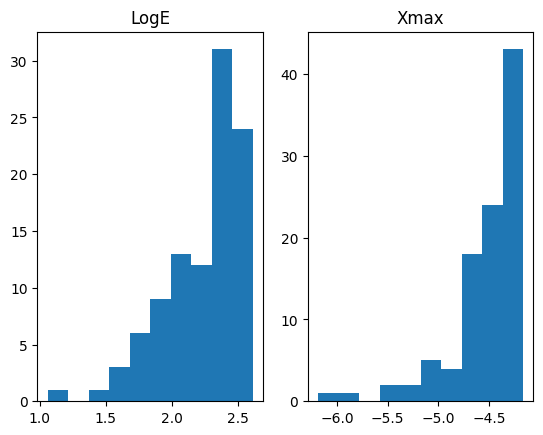

In [82]:
fig,axes = plt.subplots(1,2)

axes[0].hist(predictions[0].detach().cpu().numpy(),bins = 10)
axes[0].set_title('LogE')

axes[1].hist(predictions[3].detach().cpu().numpy(),bins = 10)
axes[1].set_title('Xmax')


In [83]:
T_loss,E_loss,C_loss,A_loss,X_Loss = Loss_function(predictions,(batchlogE,batchCore,batchAxis,batchXmax),model_Coefficients)

In [84]:
print('T_loss: ',T_loss.item())
print('E_loss: ',E_loss.item())
print('C_loss: ',C_loss.item())
print('A_loss: ',A_loss.item())
print('X_loss: ',X_Loss.item())

T_loss:  79.80170440673828
E_loss:  8.935274124145508
C_loss:  32.94670104980469
A_loss:  21.08374786376953
X_loss:  16.835981369018555


In [85]:
optimiser.zero_grad()
T_loss.backward()
optimiser.step()
